# 2 Train and Test Partition

With the populations per instrument now selected, the samples shall be partitioned for training and testing.

## Setup

In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [18]:
# read in prepared dataset from previous step
df = pd.read_pickle("data/interim/1_selected_pops.pkl")
wavelength_cols = df.filter(regex="^\d+", axis=1).columns.tolist()
descriptive_cols = [col for col in df.columns if col not in wavelength_cols]
df

,origin,population,date,season,region,cultivar,physio_stage,temp,reference_no,dry_matter,...,1173,1176,1179,1182,1185,1188,1191,1194,1197,1200
0,published,100100,2015-09-27,2015,NT,caly,green,high,1,12.402643,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,published,100100,2015-09-27,2015,NT,caly,green,high,1,12.402643,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,published,100100,2015-09-27,2015,NT,caly,green,low,1,12.402643,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,published,100100,2015-09-27,2015,NT,caly,green,low,1,12.402643,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,published,100100,2015-09-27,2015,NT,caly,green,high,2,12.430130,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85396,marcelo,200800,NaT,2021,QLD,keitt,green,undef,10676,22.502700,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
85397,marcelo,200800,NaT,2021,QLD,keitt,green,undef,10677,22.888390,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
85398,marcelo,200800,NaT,2021,QLD,keitt,green,undef,10678,22.975740,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
85399,marcelo,200800,NaT,2021,QLD,keitt,green,undef,10679,23.211150,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Examine data

In [19]:
# get number of unique instruments and samples per population
categories = (
    df
    .groupby(["season", "population"])
    .agg({"instrument": "nunique", "spectra_no": "nunique", "reference_no": "nunique"})
    .reset_index()
)
categories

,season,population,instrument,spectra_no,reference_no
0,2015,100100,3,480,40
1,2015,100200,7,1040,40
2,2015,100300,7,1520,40
3,2015,100400,6,1440,40
4,2015,100500,5,1200,50
...,...,...,...,...,...
194,2021,122200,1,72,36
195,2021,122300,1,80,40
196,2021,122400,2,160,40
197,2021,200700,1,172,172


In [20]:
# get number of unique instruments and populations and number of samples per season
seasons = (
    df
    .groupby("season")
    .agg({"instrument": "nunique", "population": "nunique", "spectra_no": "nunique", "reference_no": "nunique"})
)
seasons

,instrument,population,spectra_no,reference_no
season,,,,
2015,8,25,15200,1152
2016,17,37,15310,1697
2017,16,56,27312,2322
2018,23,38,16133,2894
2019,18,14,5604,860
2020,15,18,4452,1073
2021,11,11,1390,562


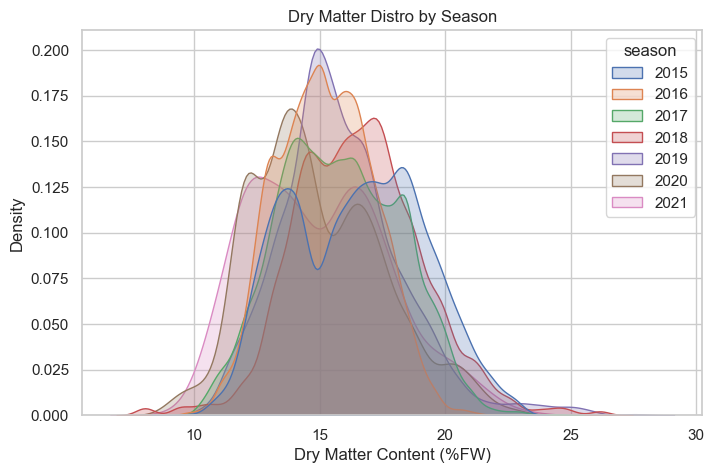

In [21]:
# plot dm distribution by season

# create a figure for a single plot
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize=(8, 5))

# plot the first set of data on the single plot
sns.kdeplot(df, x="dry_matter", hue="season", fill=True, ax=ax, palette="deep", common_norm=False)
ax.set_xlabel("Dry Matter Content (%FW)")
ax.set_ylabel("Density")
ax.set_title("Dry Matter Distro by Season")

# show the plot
plt.show()

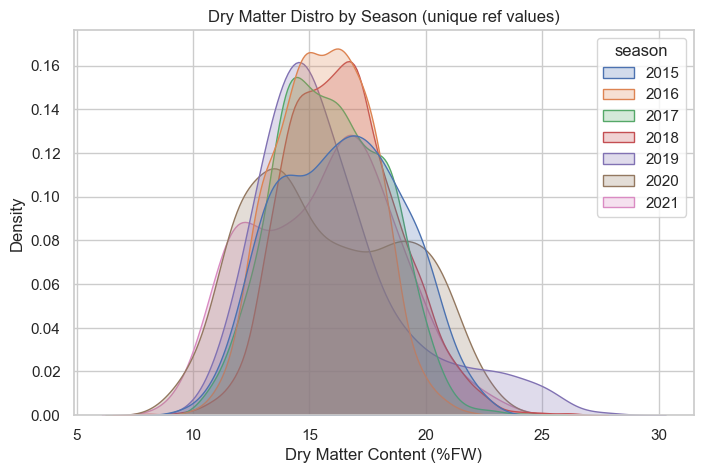

In [22]:
# plot dm distribution by season for unique reference values

# get unique reference values
df_unique_ref = df.drop_duplicates(subset=["reference_no"])

# create a figure for a single plot
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize=(8, 5))

# plot the first set of data on the single plot
sns.kdeplot(df_unique_ref, x="dry_matter", hue="season", fill=True, ax=ax, palette="deep", common_norm=False)
ax.set_xlabel("Dry Matter Content (%FW)")
ax.set_ylabel("Density")
ax.set_title("Dry Matter Distro by Season (unique ref values)")

# show the plot
plt.show()

## Assign Training and test sets

### External/Previous Partitions

In [23]:
partition_id = "partition_ext"

df.drop(columns=[partition_id], inplace=True, errors="ignore")
df.insert(loc=0, column=partition_id, value="")
df.loc[
    (df["season"] == 2018) & (df["origin"] == "published"),
    partition_id
] = "anderson_external_val"
df.loc[
    (df["instrument"] == 15006) & ((df["population"] == 112800) | (df["population"] == 112900)),
    partition_id
] = "walsh_external_val"

### Partition 1

In [24]:
partition_id = "partition_1"

df.drop(columns=[partition_id], inplace=True, errors="ignore")
df.insert(loc=0, column=partition_id, value="train")
df.loc[df["season"].isin([2018, 2019]), partition_id] = "validation"
df.loc[df["season"].isin([2020, 2021]), partition_id] = "holdout"

In [25]:
df

,partition_1,partition_ext,origin,population,date,season,region,cultivar,physio_stage,temp,...,1173,1176,1179,1182,1185,1188,1191,1194,1197,1200
0,train,,published,100100,2015-09-27,2015,NT,caly,green,high,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,train,,published,100100,2015-09-27,2015,NT,caly,green,high,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,train,,published,100100,2015-09-27,2015,NT,caly,green,low,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,train,,published,100100,2015-09-27,2015,NT,caly,green,low,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,train,,published,100100,2015-09-27,2015,NT,caly,green,high,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85396,holdout,,marcelo,200800,NaT,2021,QLD,keitt,green,undef,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
85397,holdout,,marcelo,200800,NaT,2021,QLD,keitt,green,undef,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
85398,holdout,,marcelo,200800,NaT,2021,QLD,keitt,green,undef,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
85399,holdout,,marcelo,200800,NaT,2021,QLD,keitt,green,undef,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
# split the training reference values into calibration and tunning sets
train_refs, val_refs = train_test_split(
    df.query(f"{partition_id} == 'train'")["reference_no"].unique(), 
    test_size=0.2, 
    random_state=42
)
df_train = df.query(f"reference_no in {train_refs.tolist()}")
df_val = df.query(f"reference_no in {val_refs.tolist()}")
df_train.insert(loc=1, column=f"train_{partition_id}", value="calibration")
df_val.insert(loc=1, column=f"train_{partition_id}", value="tunning")

# split the test reference values into calibration and tunning sets in case its used
train_refs, val_refs = train_test_split(
    df.query(f"{partition_id} != 'train'")["reference_no"].unique(), 
    test_size=0.2, 
    random_state=24
)
df_test_cal = df.query(f"reference_no in {train_refs.tolist()}")
df_test_val = df.query(f"reference_no in {val_refs.tolist()}")
df_test_cal.insert(loc=1, column=f"train_{partition_id}", value="calibration")
df_test_val.insert(loc=1, column=f"train_{partition_id}", value="tunning")

# combine
df = pd.concat([df_train, df_val, df_test_cal, df_test_val], axis=0).sort_index()

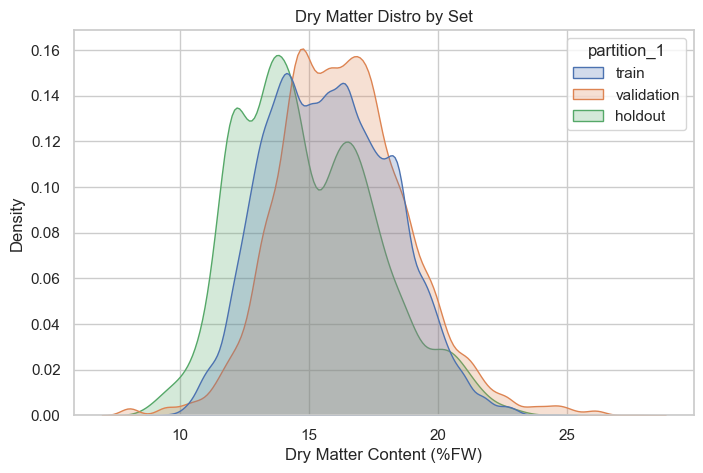

In [27]:
# plot dm distribution by set

# create a figure for a single plot
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize=(8, 5))

# plot the first set of data on the single plot
sns.kdeplot(df, x="dry_matter", hue="partition_1", fill=True, ax=ax, palette="deep", common_norm=False)
ax.set_xlabel("Dry Matter Content (%FW)")
ax.set_ylabel("Density")
ax.set_title("Dry Matter Distro by Set")

# show the plot
plt.show()

In [28]:
df.query("instrument == 15006 and season == 2018").groupby(["origin"]).size()

origin
marcelo       604
nich         1989
published    1448
dtype: int64

## Output partitioned data

In [29]:
# output
# df.to_csv("data/interim/2_partitioned.csv", index=False)
df.to_pickle("data/interim/2_partitioned.pkl")

In [30]:
df.groupby(["partition_1", "season"]).size().reset_index().sort_values("season")

,partition_1,season,0
2,train,2015,15200
3,train,2016,15310
4,train,2017,27312
5,validation,2018,16133
6,validation,2019,5604
0,holdout,2020,4452
1,holdout,2021,1390


In [31]:
df.groupby(["partition_1", "train_partition_1"]).size().reset_index()

,partition_1,train_partition_1,0
0,holdout,calibration,4550
1,holdout,tunning,1292
2,train,calibration,46218
3,train,tunning,11604
4,validation,calibration,17444
5,validation,tunning,4293


In [32]:
19969 + 320 + 1448

21737